In [2]:
#Import the libraries
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import math
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Read the csv file
booking_df=pd.read_csv("hotel_bookings.csv")
booking_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [4]:
#Check the no. of NaN in all the columns
booking_df.isna().sum().sort_values(ascending=False)

company                           112593
agent                              16340
country                              488
children                               4
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
hotel                                  0
previous_cancellations                 0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
previous_bookings_not_canceled         0
is_repeated_guest                      0
is_canceled                            0
distribution_channel                   0
market_segment                         0
meal                                   0
babies                                 0
adults                                 0
stays_in_week_ni

In [5]:
#Replace the NaN values with mean and mode
booking_df['agent'].fillna(round(booking_df.agent.mean()),inplace=True)
booking_df['children'].fillna(round(booking_df.children.mean()),inplace=True)
booking_df['company'].fillna(round(booking_df.company.mean()),inplace=True)
booking_df['country'].fillna(round(booking_df.company.mode()),inplace=True)

In [6]:
#Create a new df to work with
booking_df_drop=booking_df.copy()

In [7]:
#EDA

def plot(x, y, x_label=None,y_label=None, title=None, figsize=(10,5), type=None):
    sns.set_style('whitegrid')
    
    fig, ax = plt.subplots(figsize=figsize)
    if x_label != None:
        ax.set_xlabel(x_label)
    if y_label != None:
        ax.set_ylabel(y_label)
    if title != None:
        ax.set_title(title)
    if type == 'bar':
        sns.barplot(x=x,y=y, ax = ax)
    elif type == 'line':
        sns.lineplot(x=x,y=y, ax = ax)
    plt.show()

def get_count(ser, limit=None):

    if limit != None:
        ser = ser.value_counts()[:limit]
    else:
        ser = ser.value_counts()
    
    x = ser.index
    y = ser/ser.sum()*100
    
    return x.values,y.values

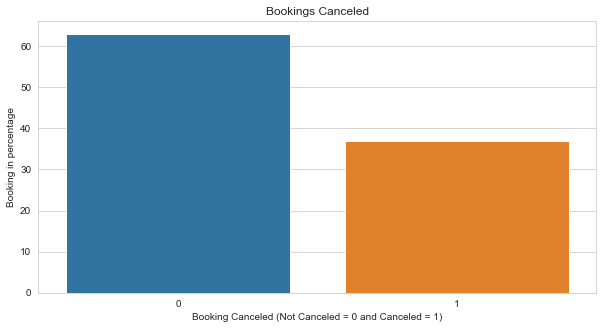

In [8]:
#How many booking were cancelled?

x,y=get_count(booking_df_drop['is_canceled'])
plot(x,y,x_label='Booking Canceled (Not Canceled = 0 and Canceled = 1)',y_label='Booking in percentage',title='Bookings Canceled',type='bar')

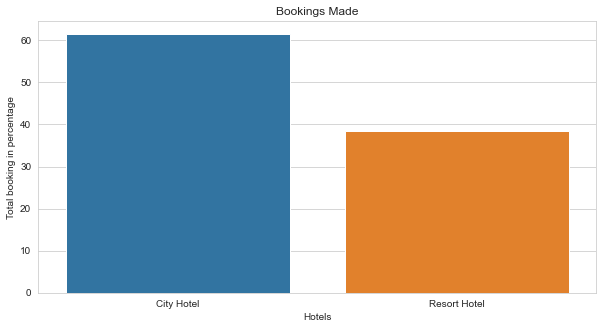

In [9]:
#Booking ratio

df_not_canceled=booking_df_drop[booking_df_drop['is_canceled']==0]
df_not_canceled

x,y= get_count(df_not_canceled['hotel'])
plot(x,y,x_label='Hotels',y_label='Total booking in percentage',title='Bookings Made',type='bar')

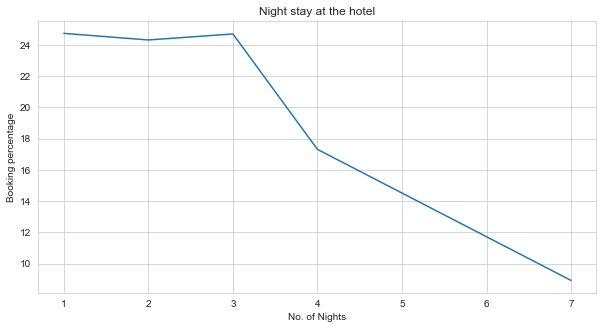

In [10]:
#How long does a customer stay in a hotel?

total_nights=df_not_canceled['stays_in_weekend_nights']+df_not_canceled['stays_in_week_nights']
x,y=get_count(total_nights,limit=5)

plot(x,y,x_label='No. of Nights',y_label='Booking percentage',title='Night stay at the hotel',figsize=(10,5),type='line')

In [11]:
#Label encode the categorical variables

le=LabelEncoder()
cols = ['hotel','market_segment', 'meal', 'country','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type','reservation_status','reservation_status_date']
booking_df_drop[cols] = booking_df_drop[cols].apply(le.fit_transform)
booking_df_drop.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,0,342,2015,July,27,1,0,0,2,...,0,87.0,189.0,0,2,0.0,0,0,1,121
1,1,0,737,2015,July,27,1,0,0,2,...,0,87.0,189.0,0,2,0.0,0,0,1,121
2,1,0,7,2015,July,27,1,0,1,1,...,0,87.0,189.0,0,2,75.0,0,0,1,122
3,1,0,13,2015,July,27,1,0,1,1,...,0,304.0,189.0,0,2,75.0,0,0,1,122
4,1,0,14,2015,July,27,1,0,2,2,...,0,240.0,189.0,0,2,98.0,0,1,1,123


[Text(0.5, 0, 'hotel'),
 Text(1.5, 0, 'is_canceled'),
 Text(2.5, 0, 'lead_time'),
 Text(3.5, 0, 'arrival_date_year'),
 Text(4.5, 0, 'arrival_date_week_number'),
 Text(5.5, 0, 'arrival_date_day_of_month'),
 Text(6.5, 0, 'stays_in_weekend_nights'),
 Text(7.5, 0, 'stays_in_week_nights'),
 Text(8.5, 0, 'adults'),
 Text(9.5, 0, 'children'),
 Text(10.5, 0, 'babies'),
 Text(11.5, 0, 'meal'),
 Text(12.5, 0, 'country'),
 Text(13.5, 0, 'market_segment'),
 Text(14.5, 0, 'distribution_channel'),
 Text(15.5, 0, 'is_repeated_guest'),
 Text(16.5, 0, 'previous_cancellations'),
 Text(17.5, 0, 'previous_bookings_not_canceled'),
 Text(18.5, 0, 'reserved_room_type'),
 Text(19.5, 0, 'assigned_room_type'),
 Text(20.5, 0, 'booking_changes'),
 Text(21.5, 0, 'deposit_type'),
 Text(22.5, 0, 'agent'),
 Text(23.5, 0, 'company'),
 Text(24.5, 0, 'days_in_waiting_list'),
 Text(25.5, 0, 'customer_type'),
 Text(26.5, 0, 'adr'),
 Text(27.5, 0, 'required_car_parking_spaces'),
 Text(28.5, 0, 'total_of_special_requests'),

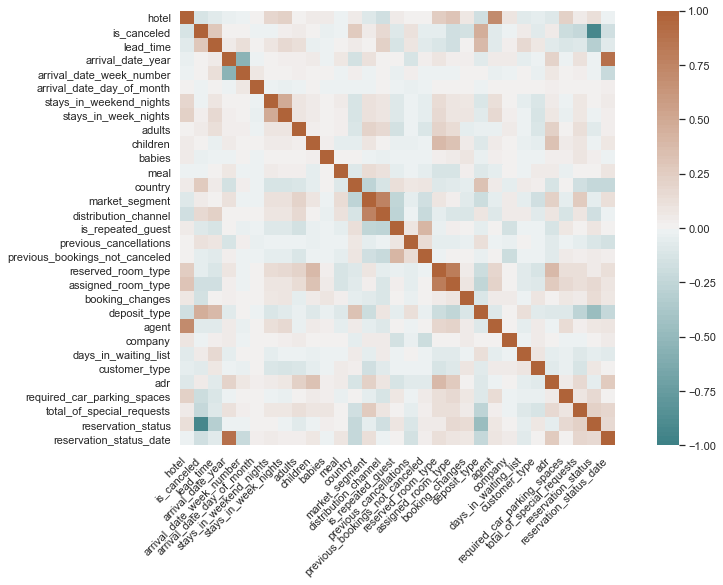

In [12]:
#Find the corelation between the variables
corr=booking_df_drop.corr()
sns.set(rc = {'figure.figsize':(15,8)})
ax=sns.heatmap(corr,vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(200,30,n=100),square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

In [13]:
#Drop irrelevent columns which are not needed
booking_df_drop.drop(['arrival_date_month', 'meal','customer_type', 'reservation_status', 'reservation_status_date'], axis = 1, inplace=True)

In [14]:
#Take only the columns needed to build the model into y and X variables
y = np.array(booking_df_drop['is_canceled'])
X = np.array(booking_df_drop[["hotel","lead_time","country","distribution_channel","previous_cancellations","assigned_room_type","booking_changes","required_car_parking_spaces","total_of_special_requests","deposit_type"]])

In [15]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(89542, 10) (29848, 10) (89542,) (29848,)


In [16]:
#Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.769326 (0.003683)
RF: 0.817974 (0.002486)
KNN: 0.809050 (0.003919)
CART: 0.806203 (0.003463)
NB: 0.452458 (0.001940)


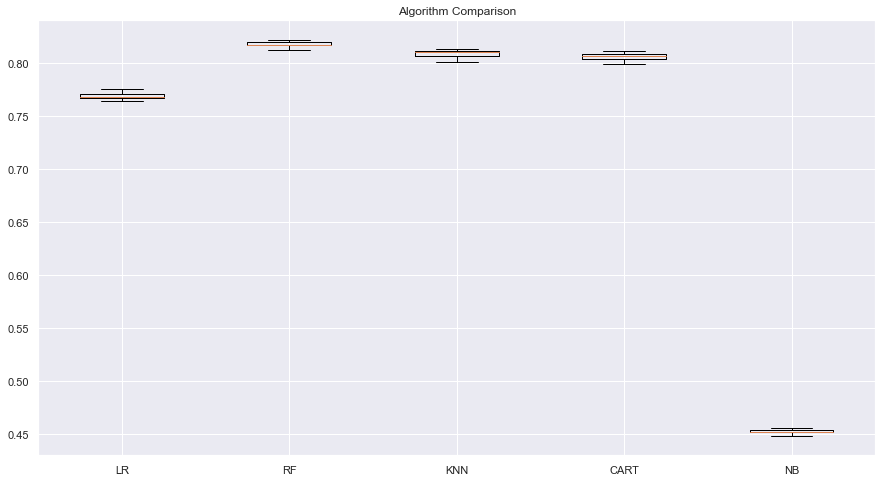

In [18]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [19]:
# Make predictions on validation dataset
model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [32]:
# Evaluate predictions
accu1=accuracy_score(y_test, predictions)
print(accu1)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8225006700616456
[[16751  2102]
 [ 3196  7799]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     18853
           1       0.79      0.71      0.75     10995

    accuracy                           0.82     29848
   macro avg       0.81      0.80      0.80     29848
weighted avg       0.82      0.82      0.82     29848



In [21]:
gridParams = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 250, 500]
}

# Define  and grid search.
rfc = RandomForestClassifier()
rfc_gridsearch = GridSearchCV(rfc, gridParams, cv=5, scoring='r2', n_jobs=-1) 

# Model fit with early stopping.
rfc_gridsearch.fit(X_train, y_train)

# Confirm what parameters were selected.
rfc_gridsearch.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 250}

In [36]:
# Make predictions on validation dataset after hyperparameter tuning
model_hp = RandomForestClassifier(bootstrap=True,max_depth=50,max_features=3,min_samples_leaf=3,min_samples_split=8,n_estimators=250)
model_hp.fit(X_train, y_train)
predictions_hp = model_hp.predict(X_test)

# Evaluate predictions
accu2=accuracy_score(y_test, predictions_hp)
print(accu2)
print(confusion_matrix(y_test, predictions_hp))
print(classification_report(y_test, predictions_hp))

#Increase in accuracy
inc=(accu2-accu1)/accu1*100
print("Increase in accuracy after Hyperparameter tuning",round(inc,2),'%')


0.8331211471455374
[[17500  1353]
 [ 3628  7367]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     18853
           1       0.84      0.67      0.75     10995

    accuracy                           0.83     29848
   macro avg       0.84      0.80      0.81     29848
weighted avg       0.83      0.83      0.83     29848

Increase in accuracy after Hyperparameter tuning 1.29 %


In [22]:
# Converting string month to numerical one (Jan = 1, Feb = 2,... Dec = 12, etc.)
datetime_object = booking_df['arrival_date_month'].str[:]
month_number = np.zeros(len(datetime_object))

# Creating a new column based on numerical representation of the months
for i in range(0, len(datetime_object)):
    datetime_object[i] = datetime.datetime.strptime(datetime_object[i],"%B")
    month_number[i] = datetime_object[i].month

# Float to integer conversion
month_number = pd.DataFrame(month_number).astype(int)

booking_df['arrival_date'] = booking_df['arrival_date_year'].map(str) + '-' + month_number[0].map(str) + '-' \
                       + booking_df['arrival_date_day_of_month'].map(str)

booking_df['arrival_date'] = pd.to_datetime(booking_df['arrival_date'])
booking_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,87.0,189.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,87.0,189.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,87.0,189.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,189.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,189.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,394.0,189.0,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,9.0,189.0,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,9.0,189.0,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,89.0,189.0,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31


In [23]:
# Calculating total guests for each record
booking_df['Total Guests'] = booking_df['adults'] + booking_df['children']
booking_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,Total Guests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,189.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,189.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,189.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,1.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,189.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,1.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,189.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,189.0,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30,2.0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,189.0,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31,3.0
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,189.0,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31,2.0
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,189.0,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31,2.0


In [24]:
# Creating two dataframes include only discrete hotel type
Resort_df = booking_df[booking_df['hotel'] == 'Resort Hotel']
City_df = booking_df[booking_df['hotel'] == 'City Hotel']

Resort_df=Resort_df.reset_index(drop=True)
City_df = City_df.reset_index(drop=True)

In [25]:
# Calculating Number of Guests Weekly - Resort Hotel
NumberOfGuests_Resort = Resort_df[['arrival_date', 'Total Guests']]
Resort_Guests_Weekly = Resort_df['Total Guests'].groupby(Resort_df['arrival_date']).sum().to_frame()
Resort_Guests_Weekly = Resort_Guests_Weekly.resample('w').sum()
Resort_Guests_Weekly

,Total Guests
arrival_date,
2015-07-05,469.0
2015-07-12,604.0
2015-07-19,727.0
2015-07-26,700.0
2015-08-02,775.0
...,...
2017-08-06,1052.0
2017-08-13,879.0
2017-08-20,1047.0


In [26]:
# Calculating Number of Guests Weekly - City Hotel
NumberOfGuests_City = City_df[['arrival_date', 'Total Guests']]
City_Guests_Weekly = City_df['Total Guests'].groupby(City_df['arrival_date']).sum().to_frame()
City_Guests_Weekly = City_Guests_Weekly.resample('w').sum()
City_Guests_Weekly

,Total Guests
arrival_date,
2015-07-05,354.0
2015-07-12,440.0
2015-07-19,646.0
2015-07-26,876.0
2015-08-02,445.0
...,...
2017-08-06,1578.0
2017-08-13,1619.0
2017-08-20,1796.0


In [27]:
#Auto ARIMA model for City Hotel to get p (AR), d (I) and q (MA) values for ARIMA model

trainCity = City_Guests_Weekly[:86]
testCity = City_Guests_Weekly[86:]

arima_fit_City = auto_arima(trainCity['Total Guests'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore', # we don't want to know if an order does not work
                          suppress_warnings=True, # we don't want convergence warnings
                          stepwise=True) # set to stepwise
print("Auto ARIMA for City Hotel")
arima_fit_City.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.03 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1171.723, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1080.094, Time=0.35 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1169.779, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1089.940, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1078.920, Time=1.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1155.815, Time=0.46 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1078.277, Time=0.81 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1079.799, Time=0.34 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1077.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   86
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -531.809
Date:                            Fri, 18 Feb 2022   AIC                           1075.617
Time:                                    10:33:07   BIC                           1089.442
Sample:                                         0   HQIC                          1081.132
                                             - 86                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6123      0.126      4.871      0.000       0.366       0.859
ar.L2          0.0655      0.175      0.373      0.709      -0.278       0.409
ar.L3          0.2122      0.140      1.519      0.129      -0.062       0.486
ar.S.L12      -0.6767      0.183     -3.698      0.000      -1.035      -0.318
ar.S.L24      -0.3481      0.150     -2.325      0.020      -0.641      -0.055
sigma2      9.683e+04   1.91e+04      5.080      0.000    5.95e+04    1.34e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.76   Prob(JB):                         0.58
Heteroskedasticity (H):               0.86   Skew:                            -0.27
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
#Auto ARIMA model for Resort Hotel to get p (AR), d (I) and q (MA) values for ARIMA model

trainResort = Resort_Guests_Weekly[:86]
testResort = Resort_Guests_Weekly[86:]

arima_fit_Resort = auto_arima(trainResort['Total Guests'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore', # we don't want to know if an order does not work
                          suppress_warnings=True, # we don't want convergence warnings
                          stepwise=True) # set to stepwise
print("Auto ARIMA for Resort Hotel")
arima_fit_Resort.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1034.434, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1007.292, Time=0.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1032.898, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1013.262, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=999.310, Time=0.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1021.897, Time=0.32 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=992.549, Time=0.75 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=999.781, Time=0.30 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=993.634, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   86
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -490.370
Date:                            Fri, 18 Feb 2022   AIC                            990.740
Time:                                    10:33:23   BIC                           1002.260
Sample:                                         0   HQIC                           995.335
                                             - 86                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3663      0.115      3.179      0.001       0.140       0.592
ar.L2          0.3394      0.106      3.209      0.001       0.132       0.547
ar.S.L12      -0.4853      0.136     -3.565      0.000      -0.752      -0.218
ar.S.L24      -0.4097      0.135     -3.031      0.002      -0.675      -0.145
sigma2      3.117e+04   7320.476      4.258      0.000    1.68e+04    4.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.62   Prob(JB):                         0.49
Heteroskedasticity (H):               0.74   Skew:                            -0.05
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
#ARIMA model for time series forecasting for City Hotel


modelCity = ARIMA(trainCity['Total Guests'],order=(3, 0, 0),seasonal_order=(2, 1, 0, 12))
resultCity = modelCity.fit()

# Prediction of the Test data
prediction_City = resultCity.predict(86, 113, typ='levels').rename("Predictions")

#ARIMA model for time series forecasting for Resort Hotel


modelResort = ARIMA(trainResort['Total Guests'],order=(2, 0, 0),seasonal_order=(2, 1, 0, 12))
resultResort = modelResort.fit()

# Prediction of the Test data
prediction_Resort = resultResort.predict(86, 113, typ='levels').rename("Predictions")

MAPE for City Hotel:0.266247


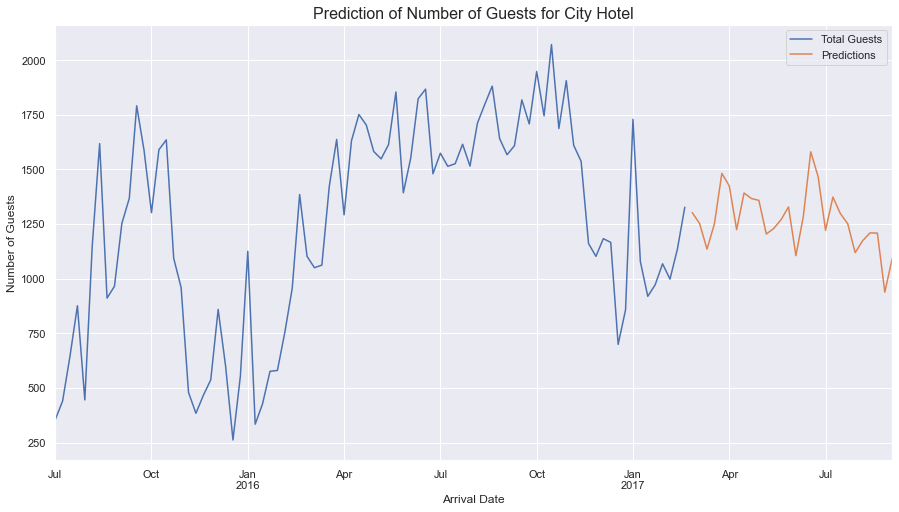

In [30]:
#No. of guests' prediction plot for City Hotel

plt.figure(figsize=(15, 8))
trainCity['Total Guests'].plot(legend=True)
prediction_City.plot(legend=True)
plt.title('Prediction of Number of Guests for City Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

MAPE_CityHotel = mean_absolute_percentage_error(testCity, prediction_City)
print('MAPE for City Hotel:{:.6f}'.format(MAPE_CityHotel))

MAPE for Resort Hotel:0.219413


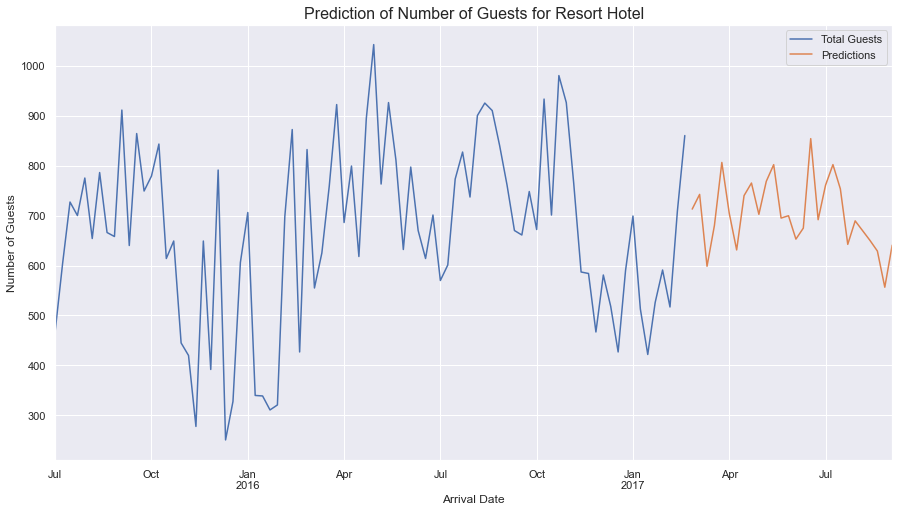

In [31]:
#No. of guests' prediction plot for Resort Hotel

plt.figure(figsize=(15, 8))
trainResort['Total Guests'].plot(legend=True)
prediction_Resort.plot(legend=True)
plt.title('Prediction of Number of Guests for Resort Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

MAPE_Resort_Hotel = mean_absolute_percentage_error(testResort, prediction_Resort)
print('MAPE for Resort Hotel:{:.6f}'.format(MAPE_Resort_Hotel))